# Multitask Regression/Classification Network State Reconstruction Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as qt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import qsttoolkit as qst

## Data Preparation

We first create batches of optical quantum state vectors of seven different varieties. `qsttoolkit.data` provides classes to produce such batches, each state with randomized parameters within given limits, based on the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework:

In [ ]:
dim = 32            # Dimensionality of the Hilbert space of the system

fock_batch = qst.data.FockStates(n_states = 1000,
                                 dim = dim,
                                 n_range = [0, dim])
coherent_batch = qst.data.CoherentStates(n_states = 1000,
                                         dim = dim,
                                         alpha_magnitude_range = [1e-6, 3])
thermal_batch = qst.data.ThermalStates(n_states = 1000,
                                       dim = dim,
                                       nbar_range = [0, dim])
num_batch = qst.data.NumStates(n_states = 1000,
                               dim = dim,
                               types = ['17', 'M', 'P', 'P2', 'M2'])
binomial_batch = qst.data.BinomialStates(n_states = 1000,
                                         dim = dim,
                                         S_range = [1, 10],
                                         mu_range = [0, 2])
cat_batch = qst.data.CatStates(n_states = 1000,
                               dim = dim,
                               alpha_magnitude_range = [0, 10])
random_batch = qst.data.RandomStates(n_states = 1000,
                                     dim = dim)

print('States generated')

/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:170: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


States generated


/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:365: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")


Parameters for noise sources that are applied to the density matrix and Husimi Q data:

In [ ]:
mixed_state_noise_level = 0.2         # Mixed state noise coefficient
Gaussian_conv_ntherm = 2.0            # Variance of the Gaussian convolution kernel
affine_theta = 20.0                   # Maximum affine transformation theta
affine_x = 0.1                        # Maximum affine transformation x shift
affine_y = 0.1                        # Maximum affine transformation y shift
additive_Gaussian_stddev = 0.001      # Additive Gaussian noise distribution standard deviation
pepper_p = 0.01                       # Pepper noise pixel probability
salt_p = 0.0                          # Salt noise pixel probability

We initialize the Husimi Q phase space before creating measurement data:

In [ ]:
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We then create density matrices and Husimi Q measurement images, applying mixed state noise using `qsttoolkit.data.mixed_state_noise()`, amplification noise using `qsttoolkit.data.gaussian_convolution()` and measurement noise using `qsttoolkit.data.apply_measurement_noise()`:

In [ ]:
fock_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
coherent_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
thermal_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
num_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
binomial_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
cat_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
random_data = pd.DataFrame(columns=['label', 'density_matrix', 'Husimi-Q_function', 'state_parameter'])
print("DataFrames initialized")

fock_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in fock_batch.density_matrices()]
fock_data['label'] = ['fock']*len(fock_densities)
fock_data['density_matrix'] = [dm.full() for dm in fock_densities]
fock_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in fock_densities]
fock_data['state_parameter'] = fock_batch.params
print("Fock data generated")

coherent_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in coherent_batch.density_matrices()]
coherent_data['label'] = ['coherent']*len(coherent_densities)
coherent_data['density_matrix'] = [dm.full() for dm in coherent_densities]
coherent_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in coherent_densities]
coherent_data['state_parameter'] = coherent_batch.params
print("Coherent data generated")

thermal_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in thermal_batch.density_matrices()]
thermal_data['label'] = ['thermal']*len(thermal_densities)
thermal_data['density_matrix'] = [dm.full() for dm in thermal_densities]
thermal_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in thermal_densities]
thermal_data['state_parameter'] = thermal_batch.params
print("Thermal data generated")

num_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in num_batch.density_matrices()]
num_data['label'] = ['num']*len(num_densities)
num_data['density_matrix'] = [dm.full() for dm in num_densities]
num_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in num_densities]
num_data['state_parameter'] = num_batch.params
print("Num data generated")

binomial_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in binomial_batch.density_matrices()]
binomial_data['label'] = ['binomial']*len(binomial_densities)
binomial_data['density_matrix'] = [dm.full() for dm in binomial_densities]
binomial_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in binomial_densities]
binomial_data['state_parameter'] = binomial_batch.params
print("Binomial data generated")

cat_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in cat_batch.density_matrices()]
cat_data['label'] = ['cat']*len(cat_densities)
cat_data['density_matrix'] = [dm.full() for dm in cat_densities]
cat_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in cat_densities]
cat_data['state_parameter'] = cat_batch.params
print("Cat data generated")

random_densities = [qst.mixed_state_noise(dm, mixed_state_noise_level) for dm in random_batch.density_matrices()]
random_data['label'] = ['random']*len(random_densities)
random_data['density_matrix'] = [dm.full() for dm in random_densities]
random_data['Husimi-Q_function'] = [qst.apply_measurement_noise(qst.gaussian_convolution(qt.qfunc(dm, xgrid, pgrid), Gaussian_conv_ntherm), affine_theta, affine_x, affine_y, additive_Gaussian_stddev, pepper_p, salt_p) for dm in random_densities]
random_data['state_parameter'] = random_batch.params
print("Random data generated")

data = pd.concat([fock_data, coherent_data, thermal_data, num_data, binomial_data, cat_data, random_data])
data = data.sample(frac=1).reset_index(drop=True)
print("Dataset generated")

DataFrames initialized
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
Random data generated
Dataset generated


Alternatively, QSTToolkit provides `optical_state_dataset()` which produces the above dataset in one function, intended to be used as a standardized dataset for training models. All the implemented noise sources are applied to the generated data, with levels that can be adjusted in the arguments:

In [ ]:
data = qst.data.optical_state_dataset(dim=32,
                                      data_dim=32,
                                      state_numbers=[1000, 1000, 1000, 1000, 1000, 1000, 0, 1000],       # Large numbers of GKP states take an intractable amount of time to produce, and are difficult to produce practically
                                      mixed_state_noise_level = 0.2,
                                      Gaussian_conv_ntherm = 2.0,
                                      affine_theta = 20.0,
                                      affine_x = 0.1,
                                      affine_y = 0.1,
                                      additive_Gaussian_stddev = 0.001,
                                      pepper_p = 0.01,
                                      salt_p = 0.0)

/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:170: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:365: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the 

States generated
DataFrames initialized
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
GKP data generated
Random data generated
Dataset generated


Inspect our dataset:

In [ ]:
data.head()

,label,density_matrix,Husimi-Q_function,state_parameter
0,coherent,"[[(0.5035284350177615+0j), (0.2772576102396807...","[[0.010231105121008579, 0.009798096294972723, ...",0.558413+0.407480j
1,thermal,"[[(0.10623593241265396+0j), (-0.00084247026276...","[[0.010925024757109492, 0.009284591077251715, ...",7.000000+0.000000j
2,cat,"[[(0.005641345597015628+0j), (0.00036535385578...","[[0.0061744729002113944, 0.006783348051377142,...",2.900470-3.216783j
3,num,"[[(0.24544803453753716+0j), (-0.00022669293539...","[[0.007594116880460395, 0.009145092844772157, ...",2.696322+0.000000j
4,random,"[[(0.03509834558335428+0j), (0.002661262773223...","[[0.009736157483686572, 0.010141768257565489, ...",0.000000+0.000000j


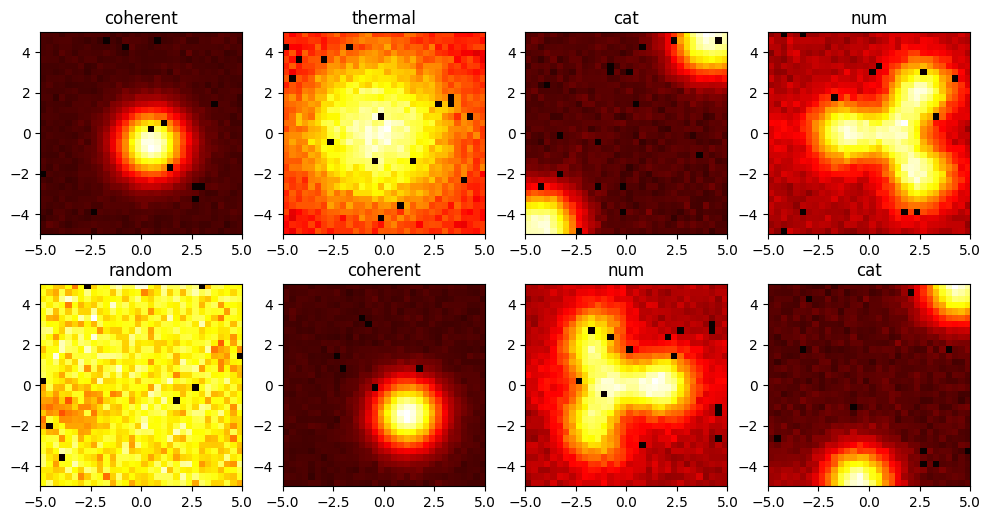

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs[0,0].imshow(data['Husimi-Q_function'][0], extent=[-5,5,-5,5], cmap='hot')
axs[0,0].set_title(data['label'][0])
axs[0,1].imshow(data['Husimi-Q_function'][1], extent=[-5,5,-5,5], cmap='hot')
axs[0,1].set_title(data['label'][1])
axs[0,2].imshow(data['Husimi-Q_function'][2], extent=[-5,5,-5,5], cmap='hot')
axs[0,2].set_title(data['label'][2])
axs[0,3].imshow(data['Husimi-Q_function'][3], extent=[-5,5,-5,5], cmap='hot')
axs[0,3].set_title(data['label'][3])
axs[1,0].imshow(data['Husimi-Q_function'][4], extent=[-5,5,-5,5], cmap='hot')
axs[1,0].set_title(data['label'][4])
axs[1,1].imshow(data['Husimi-Q_function'][5], extent=[-5,5,-5,5], cmap='hot')
axs[1,1].set_title(data['label'][5])
axs[1,2].imshow(data['Husimi-Q_function'][6], extent=[-5,5,-5,5], cmap='hot')
axs[1,2].set_title(data['label'][6])
axs[1,3].imshow(data['Husimi-Q_function'][7], extent=[-5,5,-5,5], cmap='hot')
axs[1,3].set_title(data['label'][7])
plt.show()

## Modelling

Data preprocessing:

In [ ]:
X = data['Husimi-Q_function']

y_class_raw = data['label']
label_encoder = LabelEncoder()
y_class_int = label_encoder.fit_transform(y_class_raw)

y_reg_real = data['state_parameter'].apply(lambda x: x.real)
y_reg_imag = data['state_parameter'].apply(lambda x: x.imag)
y_reg = np.array([y_reg_real, y_reg_imag]).T

X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg, indices_train, indices_test = train_test_split(X, y_class_int, y_reg, range(len(X)), test_size=0.2, random_state=42)

# Dictionaries to handle both regression and classification tasks
y_train = {"classification_output": y_train_class, "regression_output": y_train_reg}
y_test = {"classification_output": y_test_class, "regression_output": y_test_reg}
data_dim = X_train[0].shape[0]
X_train = np.array([x for x in X_train]).reshape(-1, data_dim, data_dim, 1)
X_test = np.array([x for x in X_test]).reshape(-1, data_dim, data_dim, 1)

We create an instance of the `qsttoolkit.tomography.MultitaskQuantumStateTomography` class, which handles the model architecture, compiling and training:

In [31]:
multitask_model = qst.tomography.MultitaskQuantumStateTomography(X_train=X_train,
                                                                 X_test=X_test,
                                                                 y_train=y_train,
                                                                 y_test=y_test,
                                                                 label_encoder=label_encoder,
                                                                 early_stopping_patience=30,
                                                                 lr_scheduler_factor=0.5,
                                                                 lr_scheduler_patience=15)

Model compiling and training using the `.train()` method:

In [32]:
multitask_model.train(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999),
                      classification_loss='sparse_categorical_crossentropy',
                      regression_loss='mse',
                      classification_loss_weight=1.0,
                      regression_loss_weight=1.0,
                      classification_metric='accuracy',
                      regression_metric='mse',
                      epochs=200,
                      batch_size=32,
                      validation_split=0.2,
                      verbose='auto')

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - classification_output_accuracy: 0.1428 - classification_output_loss: 2.0211 - loss: 39.6834 - regression_output_loss: 37.6623 - regression_output_mse: 37.6623 - val_classification_output_accuracy: 0.1277 - val_classification_output_loss: 2.9079 - val_loss: 48.9984 - val_regression_output_loss: 46.0904 - val_regression_output_mse: 46.0904 - learning_rate: 5.0000e-04
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - classification_output_accuracy: 0.4952 - classification_output_loss: 1.5706 - loss: 30.0294 - regression_output_loss: 28.4587 - regression_output_mse: 28.4587 - val_classification_output_accuracy: 0.2821 - val_classification_output_loss: 1.8112 - val_loss: 43.5705 - val_regression_output_loss: 41.7593 - val_regression_output_mse: 41.7593 - learning_rate: 5.0000e-04
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - classification_output_accuracy: 0.5734 - classification_output_loss: 1.1893 - loss: 31.5268 -

## Analysis and Evaluation

Inspection of accuracy and loss over training epochs:

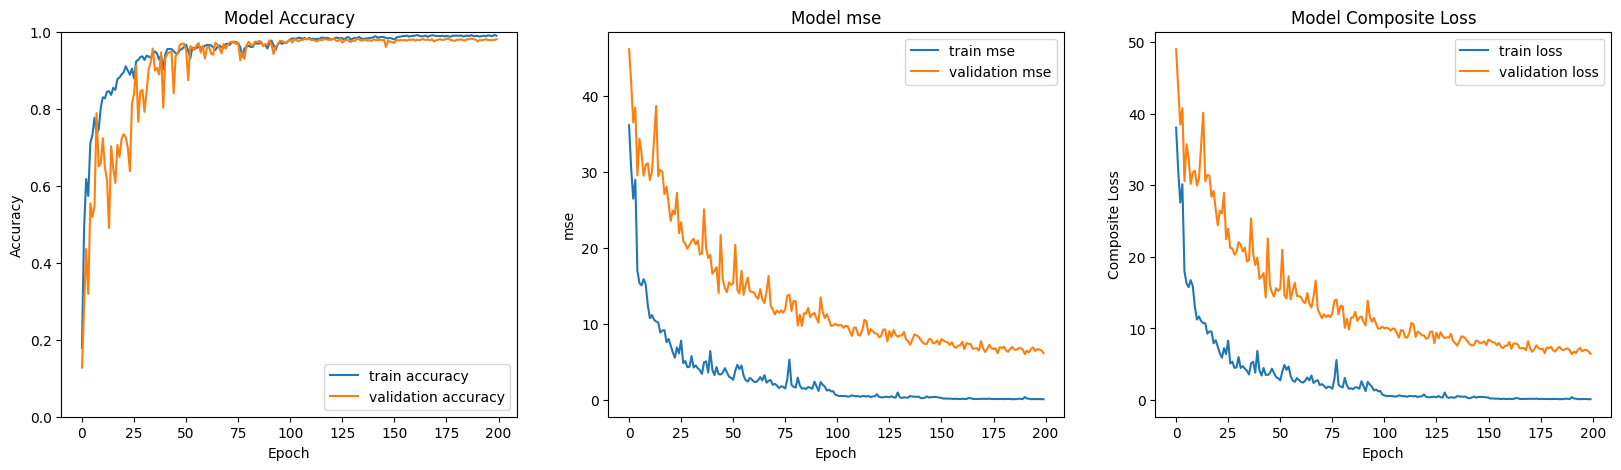

In [33]:
multitask_model.plot_training()

Model evaluation:

In [34]:
multitask_model.model.predict(X_test)[0].shape

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


(1400, 7)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


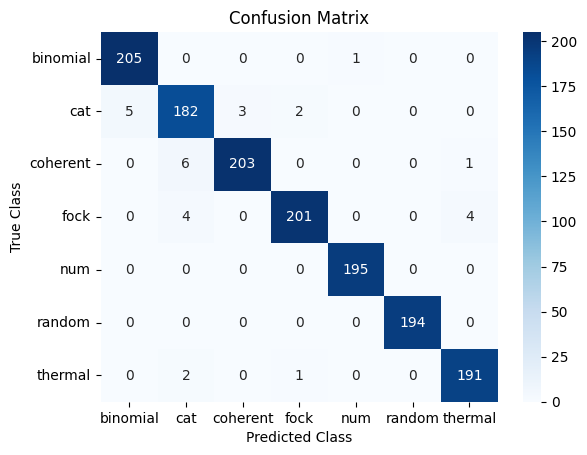

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       206
           1       0.94      0.95      0.94       192
           2       0.99      0.97      0.98       210
           3       0.99      0.96      0.97       209
           4       0.99      1.00      1.00       195
           5       1.00      1.00      1.00       194
           6       0.97      0.98      0.98       194

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400



In [35]:
multitask_model.evaluate_classification(include_confusion_matrix=True, include_classification_report=True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


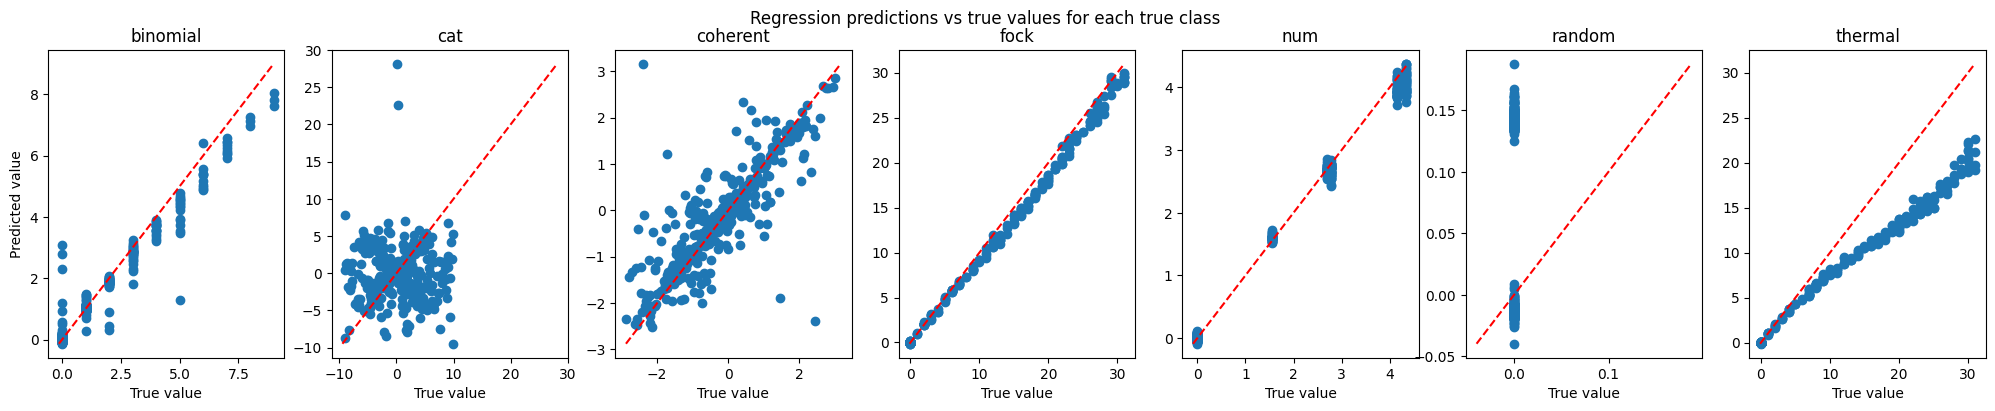

In [36]:
multitask_model.evaluate_regression()

Built-in `.infer()` method to infer labels and parameters for given input measurements and invert the label encoding, returning arrays of predicted label strings and parameter values:

In [37]:
print(multitask_model.infer(X_test))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
(array(['fock', 'random', 'random', ..., 'num', 'cat', 'cat'], dtype=object), [(18.001306533813477-0.007023152895271778j), (0.13273131847381592-0.019419636577367783j), (0.14327684044837952-0.010781456716358662j), (3.9718551635742188-0.009568867273628712j), (12.242036819458008-0.014000442810356617j), (-0.13016825914382935+0.0675620436668396j), (-0.18435317277908325+1.4627039432525635j), (0.1345638930797577-0.008945574052631855j), (1.856976866722107-0.008795646019279957j), (0.7097164392471313-1.5091139078140259j), (20.24173927307129+0.005363526754081249j), (3.997227191925049-0.057043518871068954j), (1.2050848007202148+1.2491737604141235j), (0.14597371220588684-0.009407569654285908j), (0.5243595838546753+0.19920401275157928j), (4.194652080535889+0.006755026988685131j), (0.13597679138183594+0.00026665907353162766j), (0.1393982172012329-0.016003508120775223j), (0.1411755084991455-0.017263364046812057j), (2.613461971282959+0.04668784514069557j), (8.143

`MultitaskQuantumStateTomography.model` can be treated as a `tensorflow.keras.Model` object, for example:

In [38]:
multitask_model.model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_extractor         │ (None, 204800)         │      1,577,248 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │     13,107,264 │ feature_extractor[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_20            │ (None, 64)             │              0 │ dense_8[0][0]          │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ leaky_re_lu_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │          8,320 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_21            │ (None, 128)            │              0 │ dense_9[0][0]          │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classification_output     │ (None, 7)              │            903 │ leaky_re_lu_21[0][0]   │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 204807)         │              0 │ feature_extractor[0][… │
│ (Concatenate)             │                        │                │ classification_output… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │     13,107,712 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_22            │ (None, 64)             │              0 │ dense_10[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 128)            │          8,320 │ leaky_re_lu_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_23            │ (None, 128)            │              0 │ dense_11[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │         33,024 │ leaky_re_lu_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_24            │ (None, 256)            │              0 │ dense_12[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├──────────────────────

 Total params: 84,022,589 (320.52 MB)

 Trainable params: 28,007,529 (106.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,015,060 (213.68 MB)

## Reconstructing Density Matrices from Inferred Labels and Parameters

QSTToolkit provides the `StateReconstructor` class which takes lists of inferred state labels and parameters and reconstructs the corresponding density matrices using QuTiP functions:

In [39]:
reconstructor = qst.tomography.StateReconstructor()

predicted_labels, predicted_state_parameters = multitask_model.infer(X_test)

reconstructor.add_data(true_labels = label_encoder.inverse_transform(y_test['classification_output']),
                       predicted_labels = predicted_labels,
                       true_state_parameters = y_test['regression_output'],
                       predicted_state_parameters = predicted_state_parameters,
                       true_dms = data['density_matrix'].iloc[indices_test].reset_index(drop=True))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [40]:
reconstructor.restrict_parameters(fock_n_range=[0,31], binomial_S_range=[1,10])

In [41]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_dm,reconstructed_dm,fidelity
0,fock,fock,20.000000,18.001307- 0.007023j,18.000000+ 0.000000j,"[[(0.005653446602076998+0j), (-0.0010143344110...",NaN,NaN
1,random,random,0.000000,0.132731- 0.019420j,0.132731- 0.019420j,"[[(0.02564000918465237+0j), (0.002510892024595...",NaN,NaN
2,random,random,0.000000,0.143277- 0.010781j,0.143277- 0.010781j,"[[(0.03219808143977852+0j), (-0.00400775173774...",NaN,NaN
3,num,num,4.149065,3.971855- 0.009569j,4.149065+ 0.000000j,"[[(0.006246378028796195+0j), (-0.0006016635439...",NaN,NaN
4,thermal,thermal,19.000000,12.242037- 0.014000j,12.242037- 0.014000j,"[[(0.059481107037379896+0j), (0.00114512147747...",NaN,NaN


In [42]:
reconstructor.reconstruct()

In [43]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_dm,reconstructed_dm,fidelity
0,fock,fock,20.000000,18.001307- 0.007023j,18.000000+ 0.000000j,"[[(0.005653446602076998+0j), (-0.0010143344110...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
1,random,random,0.000000,0.132731- 0.019420j,0.132731- 0.019420j,"[[(0.02564000918465237+0j), (0.002510892024595...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
2,random,random,0.000000,0.143277- 0.010781j,0.143277- 0.010781j,"[[(0.03219808143977852+0j), (-0.00400775173774...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
3,num,num,4.149065,3.971855- 0.009569j,4.149065+ 0.000000j,"[[(0.006246378028796195+0j), (-0.0006016635439...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
4,thermal,thermal,19.000000,12.242037- 0.014000j,12.242037- 0.014000j,"[[(0.059481107037379896+0j), (0.00114512147747...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN


Inspect accuracy of reconstructed states:

In [44]:
reconstructor.calculate_fidelities()

Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.


In [45]:
reconstructor.predictions_df.fidelity.mean()

np.longdouble('0.5028081234022314815')

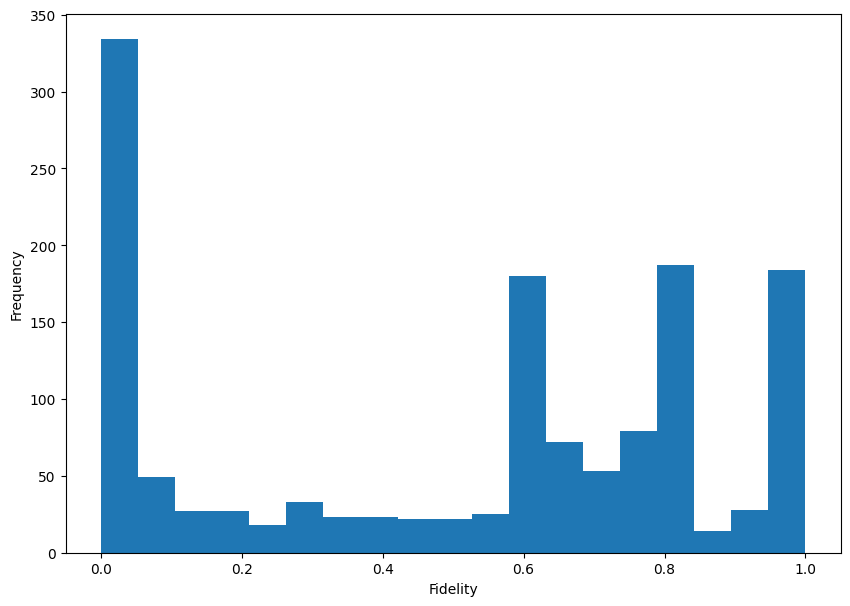

In [46]:
reconstructor.plot_fidelities(color_by_true_label=False)

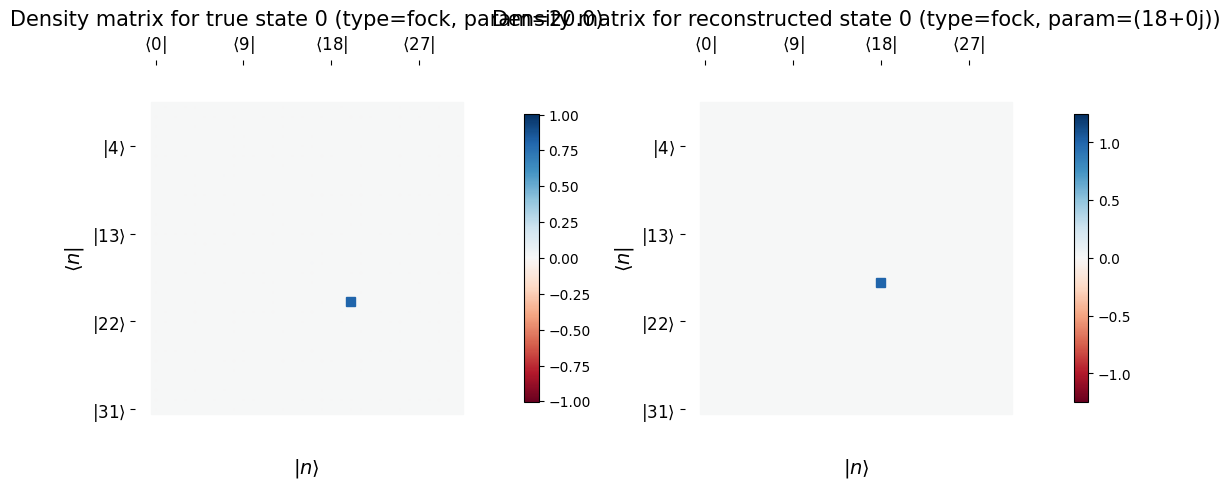

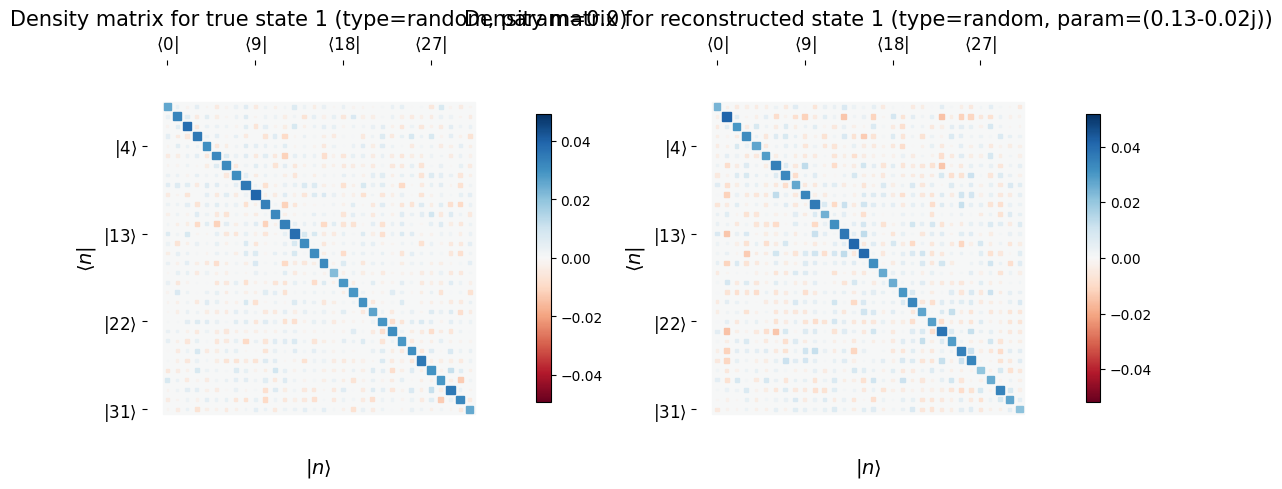

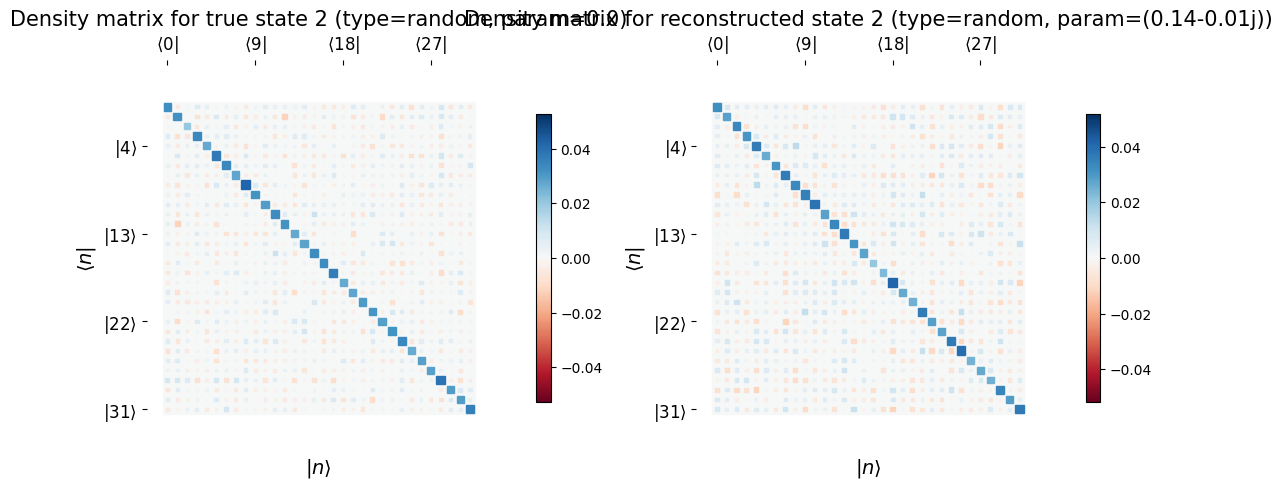

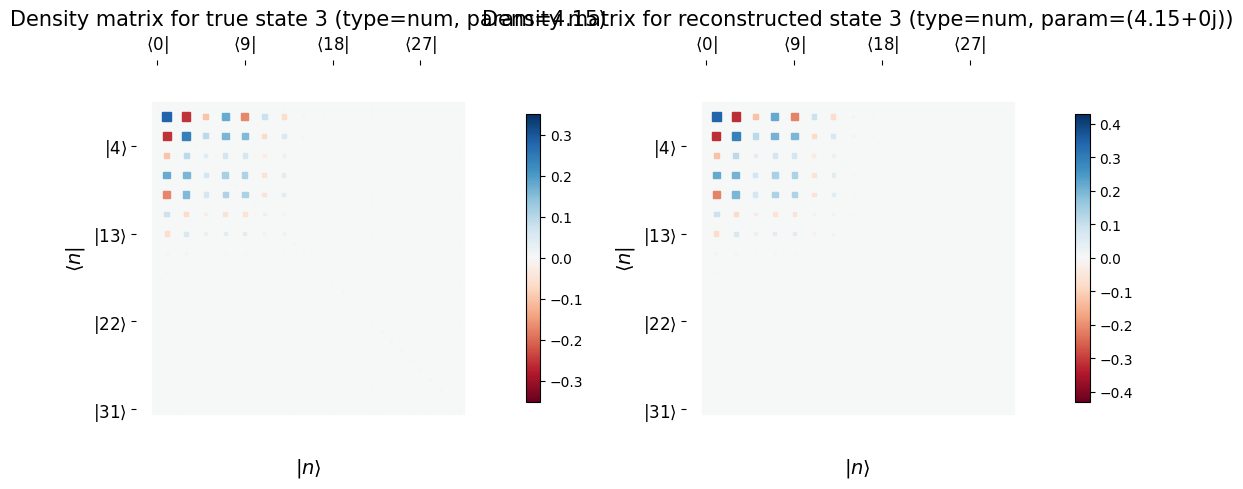

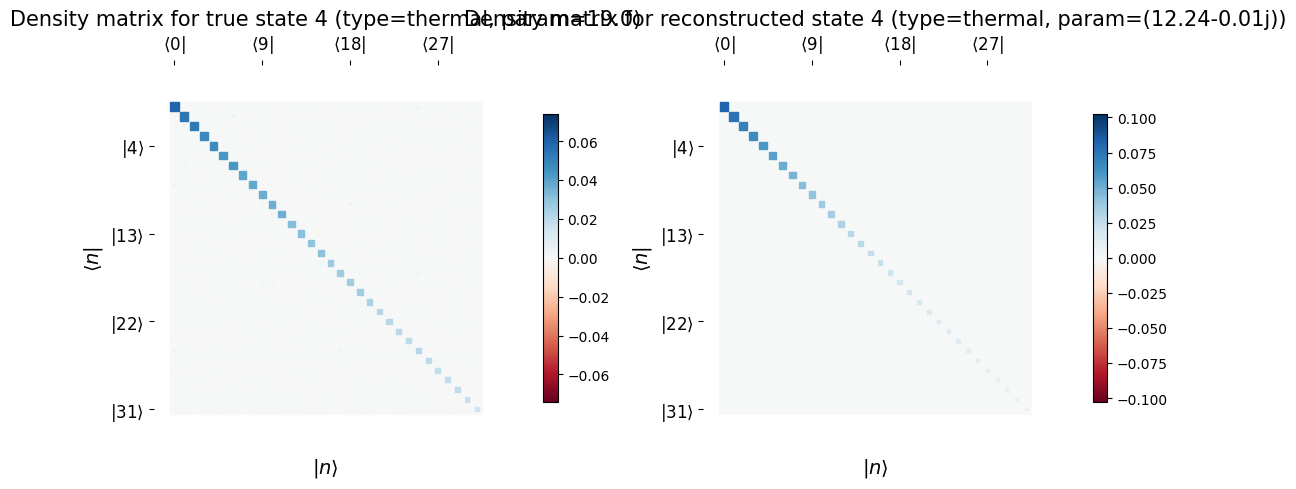

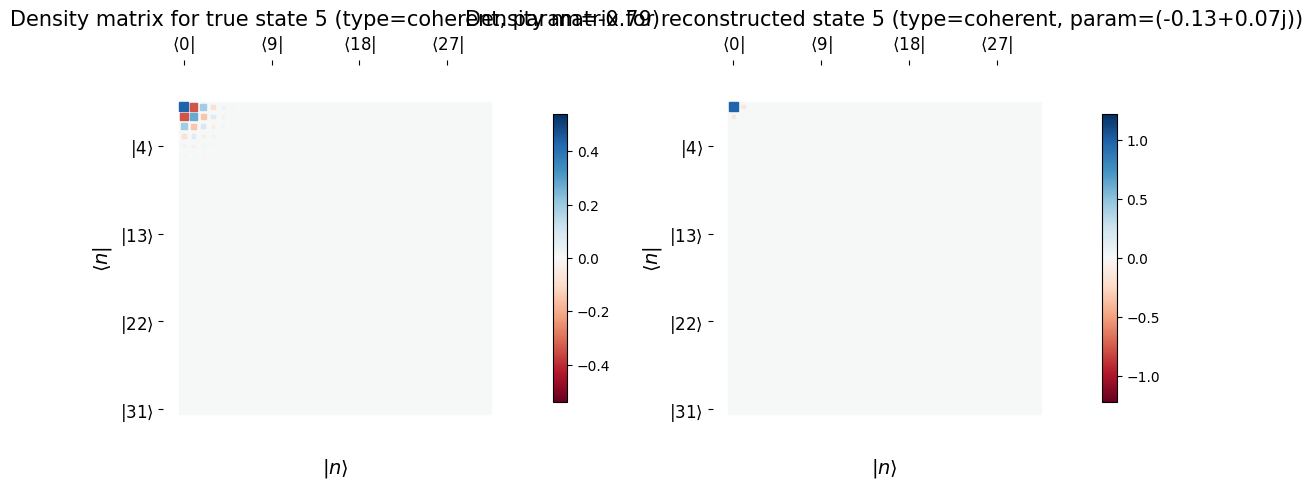

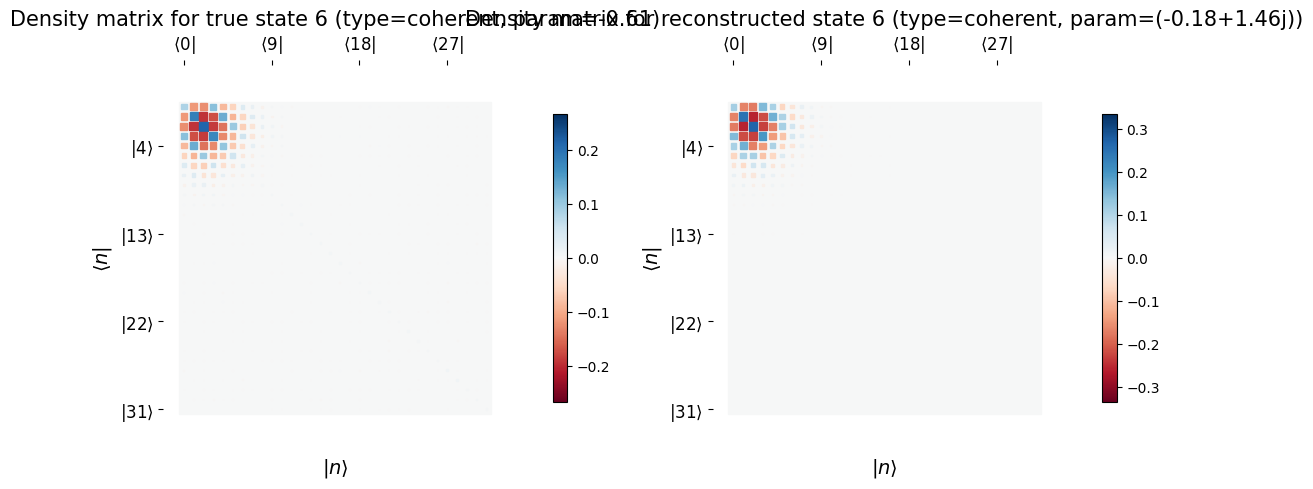

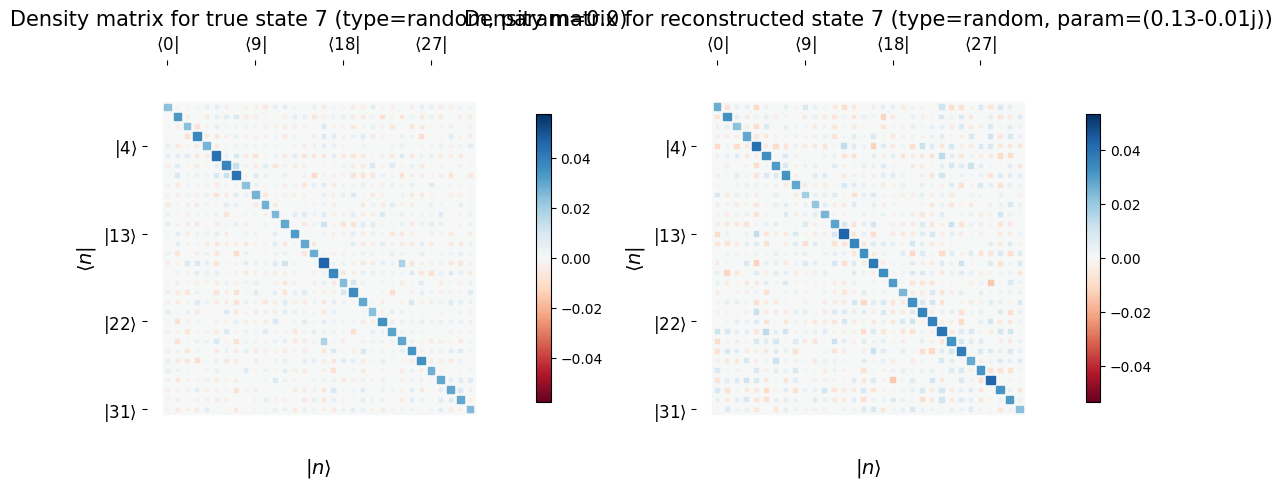

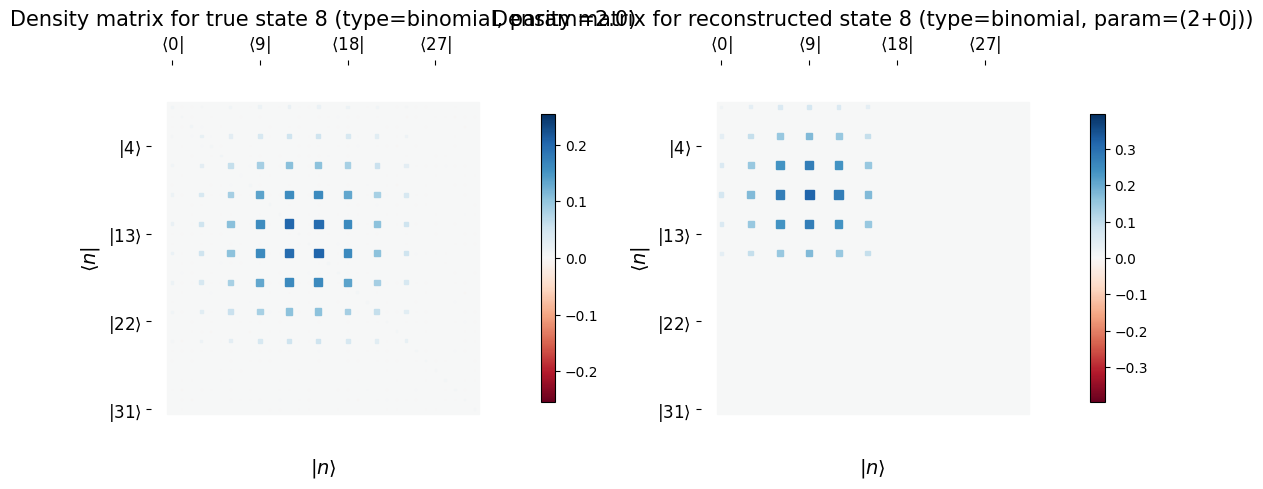

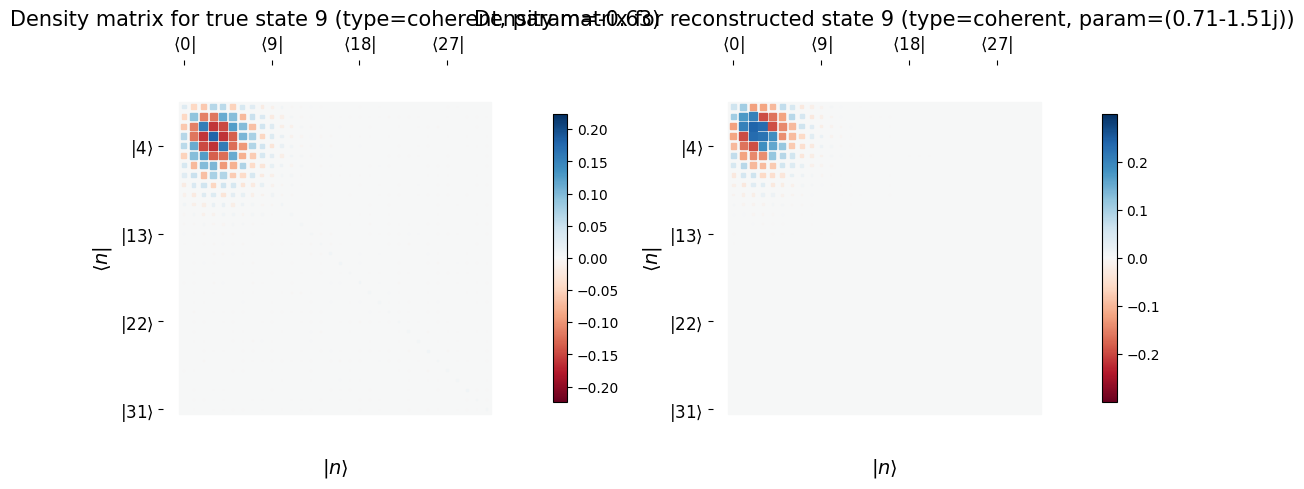

In [ ]:
reconstructor.plot_comparison_Hintons([0,10])

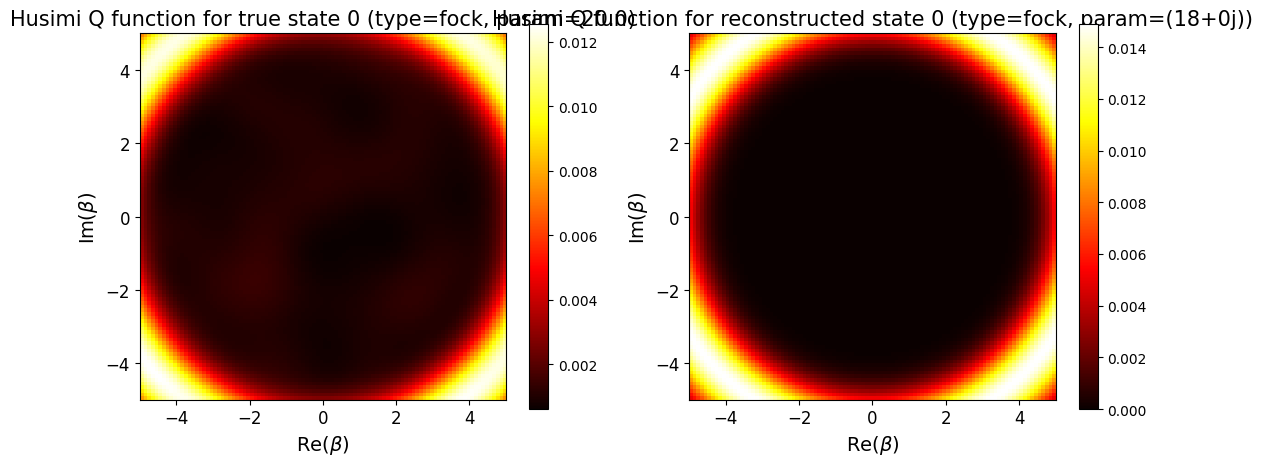

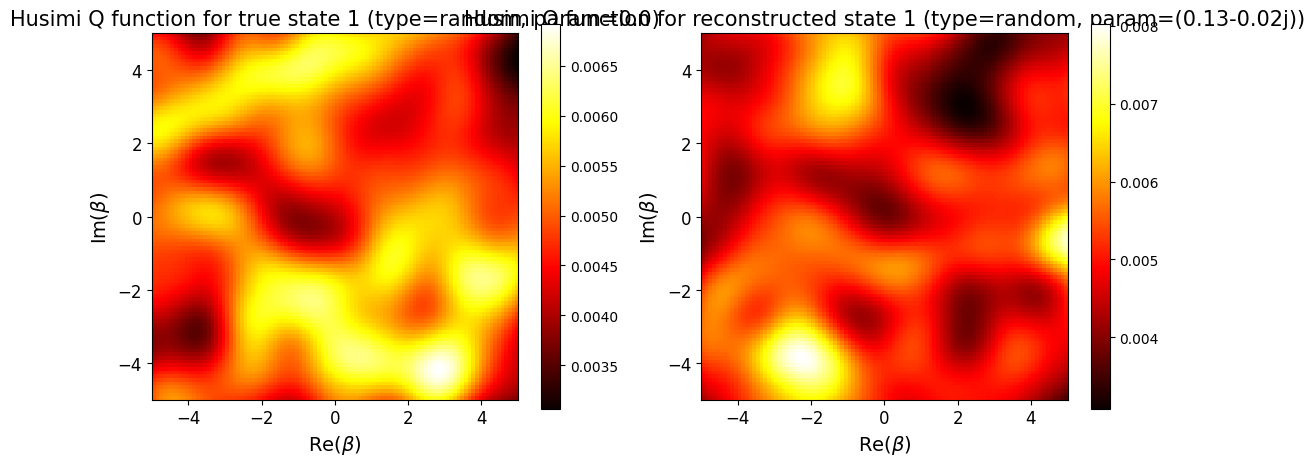

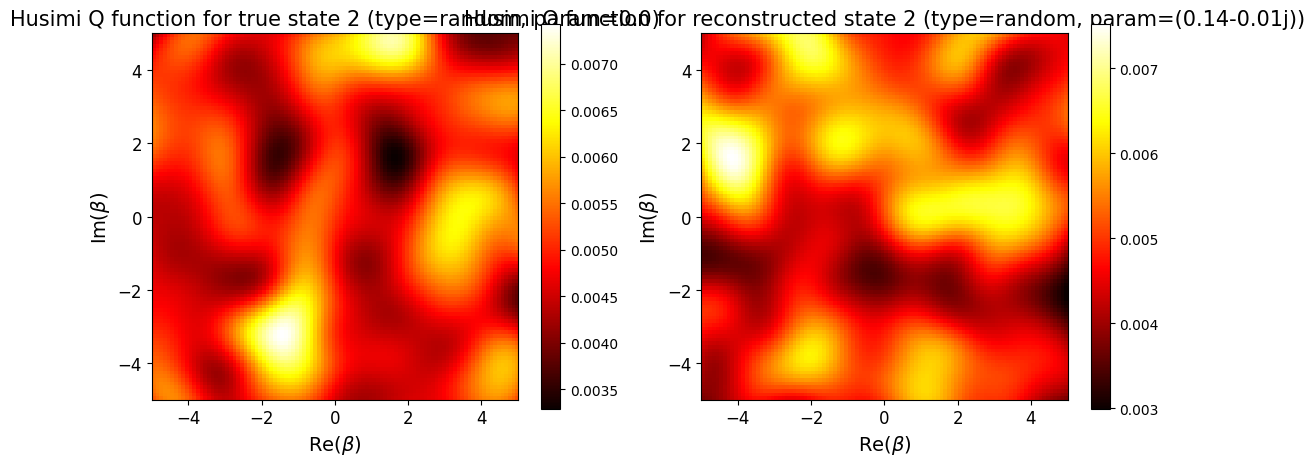

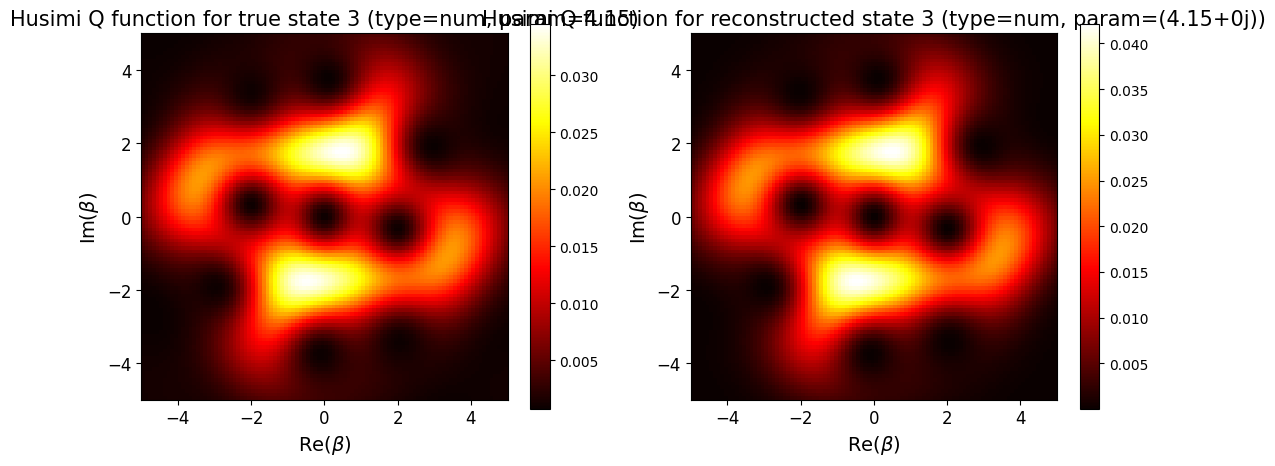

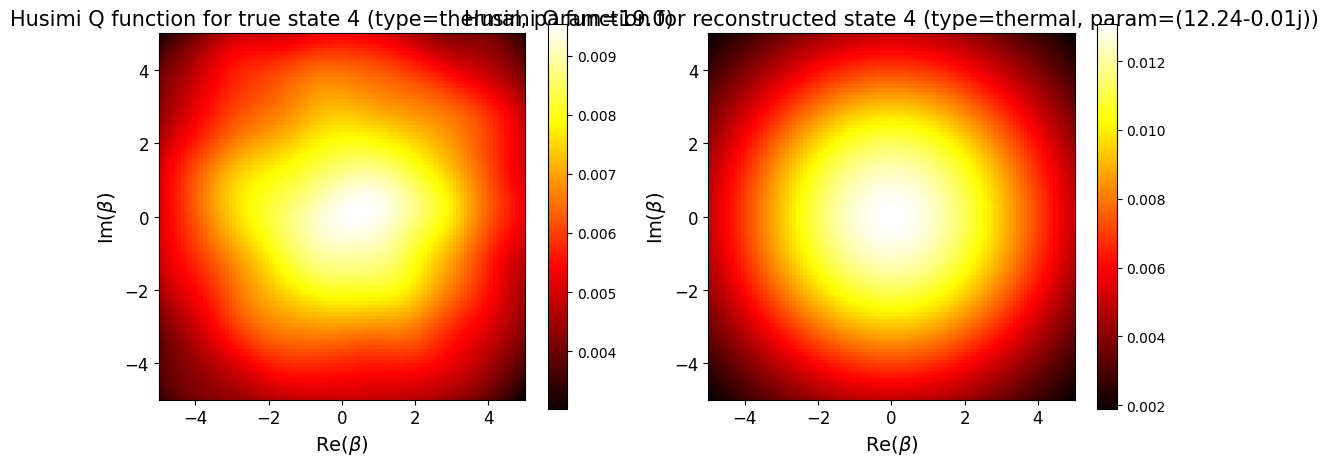

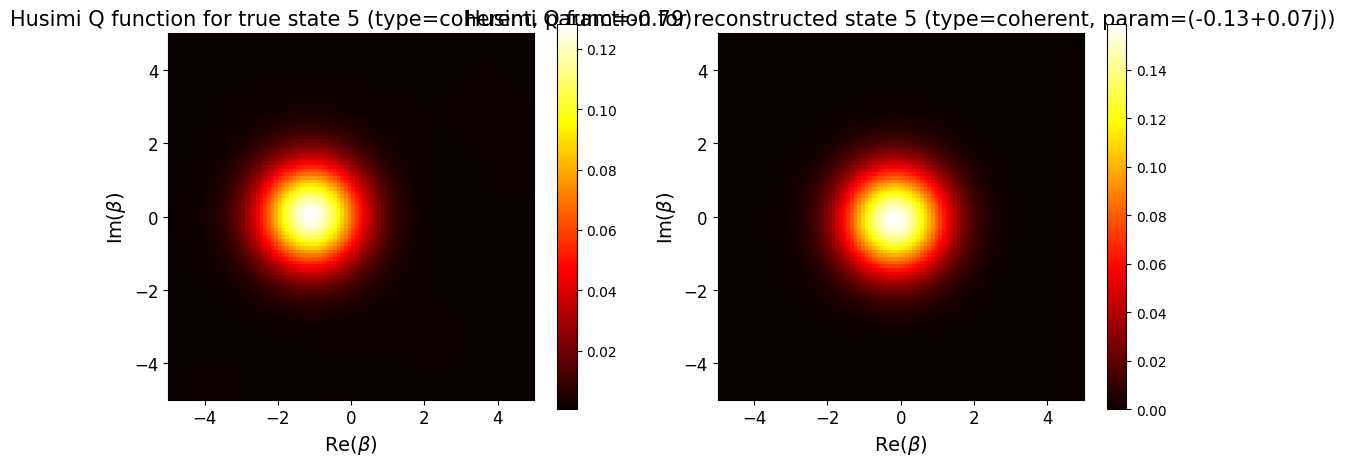

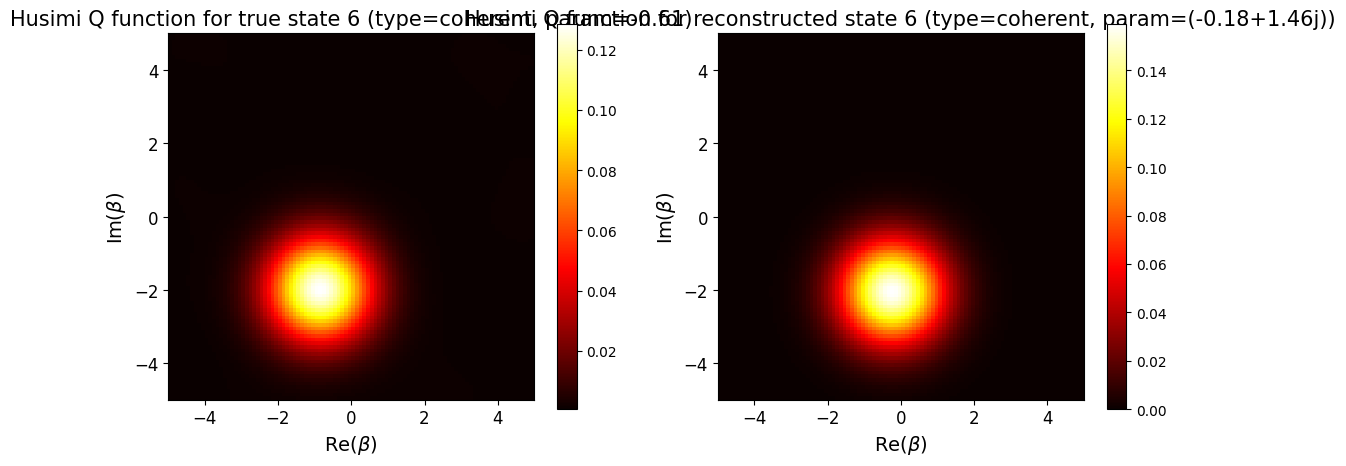

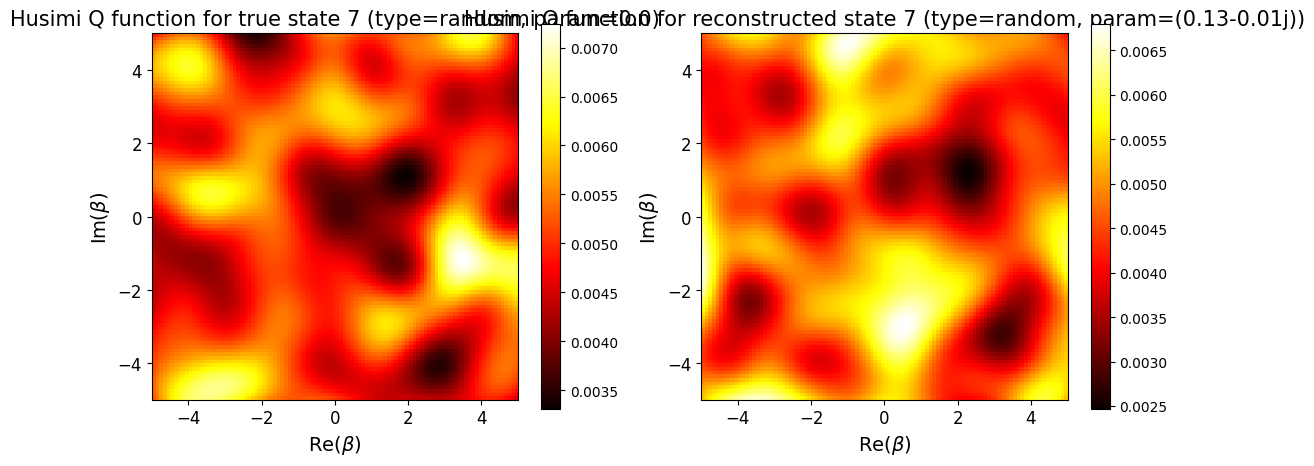

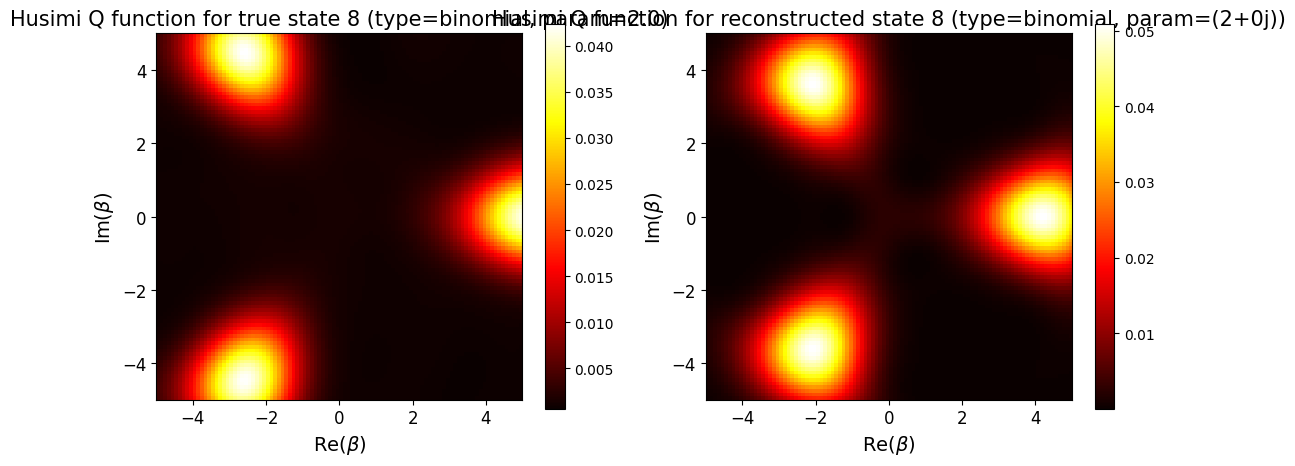

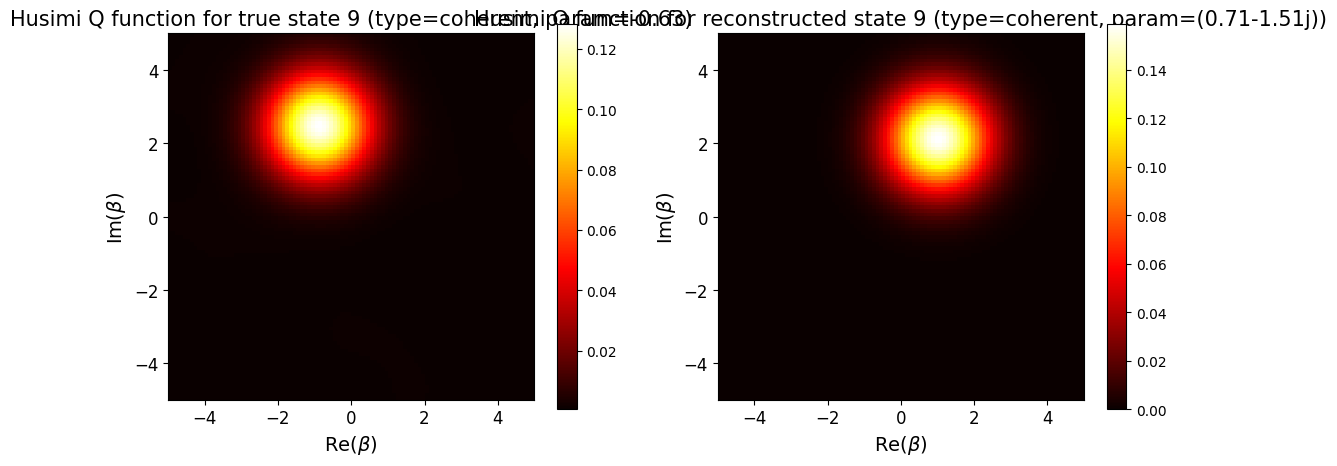

In [ ]:
reconstructor.plot_comparison_Husimi_Qs([0,10])